In [2]:
import pandas as pd
from tqdm import tqdm
from top2vec import Top2Vec
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from pathlib import Path
import yaml 
import os
import matplotlib
import igraph
from collections import Counter
import networkx as nx

from helpers.linkage import *
from helpers import dataloader
from helpers.afa import adaptive_filter
from helpers.visuals import add_cabinet_periods
from helpers import metrics as mc
from helpers import infodynamics
import seaborn as sns
from helpers.networks import *
import helpers.linkage as lkg
from helpers import style 

default_pal = style.load_style()

cf = yaml.safe_load(Path('config.yml').read_text())

/home/rb/.virtualenvs/phd_venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data = dataloader.load(cf,agg_level='speech',model_type='lda')
dists = data['dists']
labels = data['labels']
words = data['words']

dists = dists[(dists.index.year > 1945) & (dists.index.year < 1967)]

# Load merged cabinet metadata
cab_ = pd.read_csv('helpers/cabinets-merged.csv',sep='\t')
cab_['startdate'] = pd.to_datetime(cab_.startdate,infer_datetime_format=True)
cab_['enddate'] = pd.to_datetime(cab_.enddate,infer_datetime_format=True)

indices_nonsem = [k for k,v in labels.items() if 'rhet' in v or 'proc' in v]
labels_reverse =dict(zip(labels.values(),labels.keys()))

/tmp/ipykernel_261/283382609.py:11: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  cab_['enddate'] = pd.to_datetime(cab_.enddate,infer_datetime_format=True)


/tmp/ipykernel_261/3456875141.py:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  cab_['enddate'] = pd.to_datetime(cab_.enddate,infer_datetime_format=True)


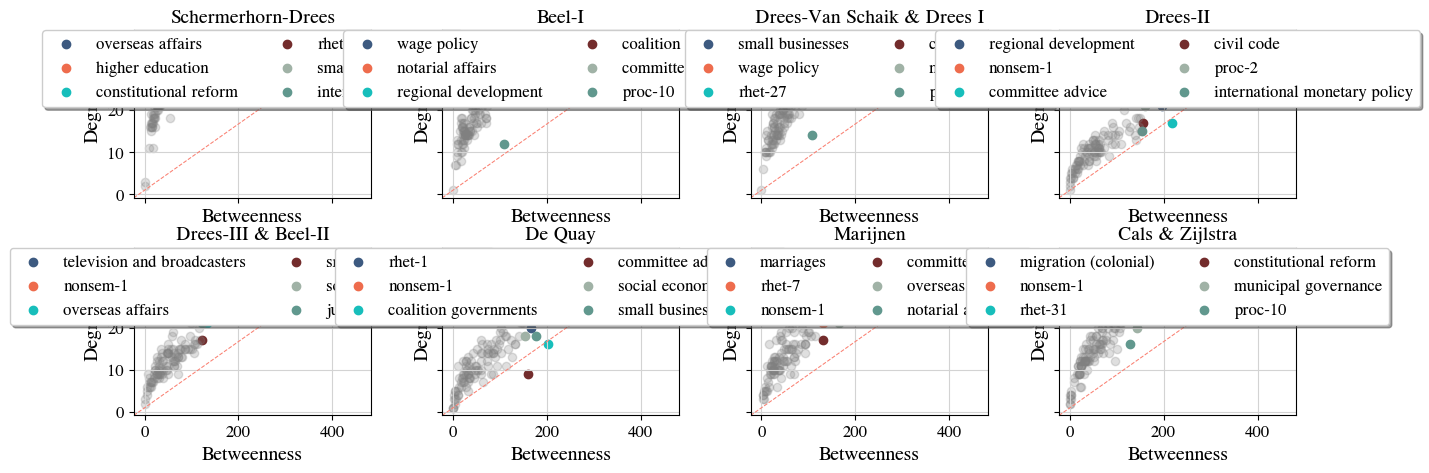

In [4]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

cab_ = pd.read_csv('helpers/cabinets-merged.csv',sep='\t')
cab_['startdate'] = pd.to_datetime(cab_.startdate,infer_datetime_format=True)
cab_['enddate'] = pd.to_datetime(cab_.enddate,infer_datetime_format=True)

fig,axs = plt.subplots(2,4,figsize=(15,5),sharey=True,sharex=True)
axs = axs.flatten()

for c,(i,r) in enumerate(cab_.iterrows()):
    mask = (dists.index > r['startdate']) & (dists.index <= r['enddate'])
    theta = dists.loc[mask].to_numpy()
    theta,_,__ = mutual_information(theta)

    g,cmty,fmx = get_network_from_mi_theta(theta,thr=0)
    btw_vals = dict(get_betweenness_values(g))
    deg_vals = dict(get_degree_values(g))

    top_btw = [k for k,v in Counter(btw_vals).most_common(6)]
    top_deg = [k for k,v in Counter(btw_vals).most_common(6)]
    top = set(top_btw + top_deg)

    xmin,xmax = axs[c].get_xlim()
    ymin,ymax = axs[c].get_ylim()

    top_pal = default_pal
    cc = 0
    for topic in deg_vals.keys():
        
        if topic in top:
            lab = labels[topic]
            axs[c].scatter([btw_vals[topic]],[deg_vals[topic]],color=top_pal[cc],alpha=1,label=lab)
            cc += 1
        if topic not in top:
            axs[c].scatter([btw_vals[topic]],[deg_vals[topic]],alpha=.25,color='grey')

    axs[c].set_title(r['cabinet'],fontsize=14)
    axs[c].set_ylabel('Degree')
    axs[c].set_xlabel('Betweenness')
    axs[c].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=2, fancybox=True, shadow=True)

    line = mlines.Line2D([0, 1], [0, 1], color='salmon',linewidth=.75,linestyle='--')
    transform = axs[c].transAxes
    line.set_transform(transform)
    axs[c].add_line(line)   

plt.subplots_adjust(hspace=.3,wspace=.3)
# plt.savefig('figs/networks-cabinets-betweenness-degree.pdf',dpi=250)
plt.show()